## I imported all the necesary data and downloaded a file of profit data for movies 

In [951]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import json
import sqlite3
import numpy as np
%matplotlib inline
from PIL import Image

thenums_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')


## I made a function that turned object columns into integer colums ###

I ran this function onto the columns of this dataframe


In [799]:
# This function turns series columns into integers
def make_column_integer(df, series):
    df[series] = df[series].str.replace('$', '')
    df[series] = df[series].str.replace(',', '')
    df[series] = df[series].astype(int)

# Turns all the columns in this dataframe into integers
make_column_integer(thenums_df, 'production_budget')
make_column_integer(thenums_df, 'domestic_gross')
make_column_integer(thenums_df, 'worldwide_gross')


## I then made 2 new columns: 

One column called "total_gross" which was the sum of the domestic and worldwide grossings, and another column called "total_profit" that is the total gross minus the production cost.



In [801]:
thenums_df['total_gross']= (thenums_df['domestic_gross'])+(thenums_df['worldwide_gross'])
thenums_df['total_profit'] = (thenums_df['total_gross']-thenums_df['production_budget'])
thenums_df.sort_values('total_profit', ascending = False, inplace=True)

# I imported a new dataframe from the IMDB database that contained the genres of the movies.

In [804]:
imdb_title_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')



# I merged the profits dataframe and the title basics dataframe



In [805]:
gandp_df = pd.merge(imdb_title_basics, thenums_df, how='inner', left_on='primary_title', right_on='movie')

In [806]:
# Sorted the values by hightest profit
gandp_df = gandp_df.sort_values('total_profit', ascending=False)

In [807]:
# Drops redundant columns
gandp_df = gandp_df.drop(columns = ['original_title', 'start_year', 'id', 'movie'])

In [808]:
# Drops the duplicated movies from the dataframe
gandp_df = gandp_df.drop_duplicates(subset='primary_title')

In [809]:
#Sets the index to their tconst
gandp_df.set_index('tconst', inplace=True)

In [810]:
#Drops all null values from the genres catagory
gandp_df.dropna(subset=['genres'], inplace=True)

In [811]:
gandp_df.at['tt1775309', 'genres'] = 'Action,Adventure,Fantasy'

# I made a list of all possible genres for each movie

In [812]:
# Puts all the genres for each movie into a list
list_of_genres = gandp_df['genres']
list_of_genres = list_of_genres.str.split(',')

In [813]:
nunique_genres=[]
for x in list_of_genres:
    for genre in x:
        nunique_genres.append(genre)

unique_genres = set(nunique_genres)

## I cleaned up and seperated the total movie database
### I moved all the movies with no gross earnings into a database called "stream_movies", and I took all the others and named the new database "theater_movies"

In [814]:
stream_movies = gandp_df.loc[gandp_df['total_gross']== 0]
stream_movies = stream_movies.sort_values(by='production_budget', ascending=False)
stream_movies = stream_movies.drop(['domestic_gross','worldwide_gross','total_gross','total_profit'], axis='columns')

In [815]:
theater_movies = gandp_df[gandp_df.total_gross != 0]

# I then broke up the dataframe into sub-dataframes, for each genre we are analyzing.
#### I then broke up the genre dataframes into theatrical releases and streaming releases


In [816]:
action_movies= theater_movies[theater_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies= theater_movies[theater_movies.genres.str.contains('Drama')]
comedy_movies= theater_movies[theater_movies.genres.str.contains('Comedy')]
horror_movies= theater_movies[theater_movies.genres.str.contains('Horror')]

In [817]:
action_movies_st= stream_movies[stream_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies_st= stream_movies[stream_movies.genres.str.contains('Drama')]
comedy_movies_st= stream_movies[stream_movies.genres.str.contains('Comedy')]
horror_movies_st= stream_movies[stream_movies.genres.str.contains('Horror')]

# This WebScrapes the taglines from IMDb for each movie
### It then organizes the first five taglines into a list for each movie

In [533]:
def get_tags(data):
    no_table = []
    list_of_tags = []
    for tconst in data.index:
        url = f'https://www.imdb.com/title/{tconst}/keywords?ref_=tt_stry_kw'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        
        try:
            table = soup.find_all('table', {'class': 'dataTable'})[0]
            a_tags = [x.find('a') for x in table.find_all('td', {'class': 'soda sodavote'})]
            if len([x.text for x in a_tags]) > 5:
                text = [x.text for x in a_tags][:5]
            else:
                text = [x.text for x in a_tags]
        
            list_of_tags.append(text)
        
        except:
            no_table.append(tconst)
            list_of_tags.append([None])
  
    return list_of_tags

### I ran this web scraping function on my 4 dataframes

In [969]:
horror_tags = get_tags(horror_movies)

In [597]:
action_tags = get_tags(action_movies)

In [598]:
comedy_tags = get_tags(comedy_movies)

In [599]:
drama_tags = get_tags(drama_movies)

In [974]:
horror_movies['tags'] = horror_tags
comedy_movies['tags'] = comedy_tags
action_movies['tags'] = action_tags
drama_movies['tags'] = drama_tags

  
# A function that creates a new dataframe for each genre (where the profits for each movie are over $1,000,000)
 

In [958]:
def get_successful(df):
    df_successes = df.loc[df['total_profit'] > 1000000]
    return df_successes

In [959]:
successful_action = get_successful(action_movies)

In [960]:
successful_comedy = get_successful(comedy_movies)

In [961]:
successful_drama = get_successful(drama_movies)

In [962]:
successful_horror = get_successful(horror_movies)

#### A funtion that spits out a dataframe for each genre of movie

In [794]:
def get_genre_db(db, genre):
    return db[db["genres"].str.contains(genre)]
get_genre_db(gandp_df, 'Adventure')

#### A function that gets the median value for profit earned for a given genre

In [778]:
def get_median():
    list_of_med_nums= []
    for genre in unique_genres:
        list_of_med_nums.append(get_genre_db(gandp_df, genre).describe()['total_profit']['50%'])
    #list_of_meds = list(zip(unique_genres,list_of_med_nums))
    return list_of_med_nums

# This Function removes the null values from the tag lists for each genre, and makes it into one list of all the tags

In [833]:
def removenulls(tag_list):
    for x in tag_list:
        if None in x:
            tag_list.remove(x)
    return tag_list

In [875]:
horror_tags_nonull = removenulls(horror_tags)
comedy_tags_nonull = removenulls(comedy_tags)
action_tags_nonull = removenulls(action_tags)
drama_tags_nonull = removenulls(drama_tags)

In [922]:
def list_all_tags(tag_list):
    all_tags = []
    for tags in tag_list:
        for tag in tags:
            if ' ' in tag:
                tag.replace(' ','-')
            elif tag == 'character':
                continue
            else:
                all_tags.append(tag)
    return all_tags

In [925]:
all_horror_tags = list_all_tags(horror_tags_nonull)
all_drama_tags = list_all_tags(drama_tags_nonull)
all_comedy_tags = list_all_tags(comedy_tags_nonull)
all_action_tags = list_all_tags(action_tags_nonull)

In [926]:
#wordcloud = WordCloud(width = 5000, height = 5000, max_words=1, background_color = 'white').generate(str(all_horror_tags))
def tt(all_tags):
    string_tag = ' '.join(all_tags).lower()
    return string_tag

In [975]:
horror_tt = tt(all_horror_tags)
drama_tt = tt(all_drama_tags)
comedy_tt = tt(all_comedy_tags)
action_tt = tt(all_action_tags)

In [976]:
!ls

DS_Project_Presentation.pdf       data
Master_Tables.ipynb               dsc-phase1-project-template.ipynb
README.md                         first_notebook_KK.ipynb
TEMPLATE_README.md                images
The_Numbers_data.ipynb            src
create_sql_database.ipynb


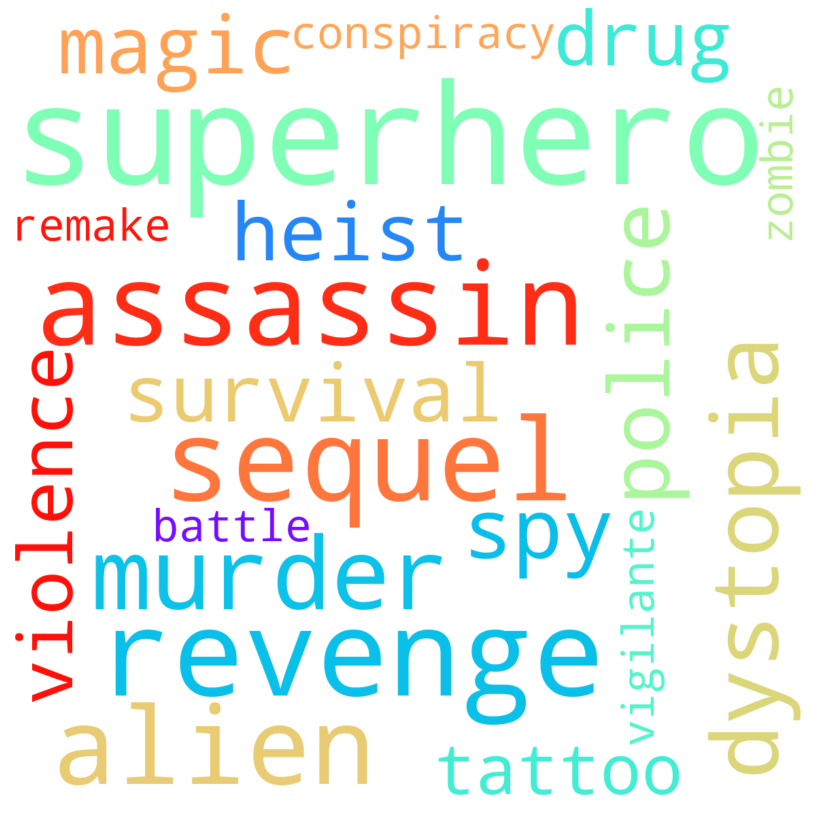

In [985]:
#create the wordcloud object
mask = np.array(Image.open('data/Mask_Circle.png'))
plt.figure(figsize=(15,15))
wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'white',
                      collocations=True, colormap = 'rainbow_r', mask = mask ).generate(action_tt)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

# This Webscrapes IMDb and gets the directors of each movie

In [991]:
url = f'https://www.imdb.com/title/tt4154796/?ref_=nv_sr_srsg_0'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')
age_rating = soup.find_all('span', {'class': "TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex"})[1]
age_rating
#<span class="TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex">PG-13</span>

bs4.element.Tag

In [977]:
def get_directors(data):
    no_table = []
    list_of_directors = []
    for tconst in data.index:
        url = f'https://www.imdb.com/title/{tconst}/?ref_=nv_sr_srsg_0'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        
        try:
            director = soup.find_all('div', {'class': 'ipc-metadata-list-item__content-container'}) #[0]
            #a_tags = [x.find('a') for x in table.find_all('td', {'class': 'soda sodavote'})]
            if len([x.text for x in a_tags]) > 2:
                text = [x.text for x in a_tags][:2]
            else:
                text = [x.text for x in a_tags]
        
            list_of_tags.append(text)
        
        except:
            no_table.append(tconst)
            list_of_tags.append([None])
  
    return list_of_tags